# El precio justo

Hoy construimos una solución más compleja para estimar los precios de los bienes.

1. Cuaderno del día 2.0: crear una base de datos RAG con nuestros 400 000 datos de entrenamiento
2. Cuaderno del día 2.1: visualizar en 2D
3. Cuaderno del día 2.2: visualizar en 3D
4. Cuaderno del día 2.3: crear y probar una canalización RAG con GPT-4o-mini
5. Cuaderno del día 2.4: (a) recuperar nuestro tasador de Bosque aleatorio (b) crear un tasador de conjunto que permita contribuciones de todos los tasadores

¡Uf! ¡Eso es mucho para hacer en un día!

## TWEN EN CUENTA:

Ya tenemos un estimador de productos muy poderoso con nuestro LLM patentado y perfeccionado. ¡La mayoría de las personas estarían muy satisfechas con eso! La razón principal por la que agregamos estos pasos adicionales es para profundizar su experiencia con RAG y con los flujos de trabajo de Agentic.

## Terminando con Random Forests y Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Cargamos el fichero test pickle:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Bosque aleatorio

Ahora entrenaremos un modelo de bosque aleatorio.

¿Puedes ver la diferencia con lo que hicimos en la semana 6? En la semana 6 usamos el modelo word2vec para formar vectores; esta vez usaremos los vectores que ya tenemos en Chroma, del modelo SentenceTransformer.

El entrenamiento del bosque aleatorio tardará más de una hora. Si te da pereza entrenarlo, tienes el fichero pickle en:
https://drive.google.com/file/d/1Axv5v5XBaFd51gROoZCQ6QHqc1Gwg146/view?usp=share_link 

In [ ]:
# ¡La siguiente línea tarda una hora en mi Mac M2!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

In [ ]:
# Guardar el modelo en un archivo

joblib.dump(rf_model, 'random_forest_model.pkl')

In [7]:
# Volvemos a cargarlo nuevamente

rf_model = joblib.load('random_forest_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.65 Truth: $225.11 Error: $28.46 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $213.42 Truth: $61.68 Error: $151.74 SLE: 1.51 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.84 Truth: $599.99 Error: $235.15 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $195.52 Truth: $16.99 Error: $178.53 SLE: 5.72 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $69.63 Truth: $31.99 Error: $37.64 SLE: 0.58 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $275.91 Truth: $101.79 Error: $174.12 SLE: 0.98 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $222.00 Truth: $289.00 Error: $67.00 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $275.46 Truth: $635.86 Error: $360.40 SLE: 0.70 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $182.72 Truth: $65.99 Error: $116.73 SLE

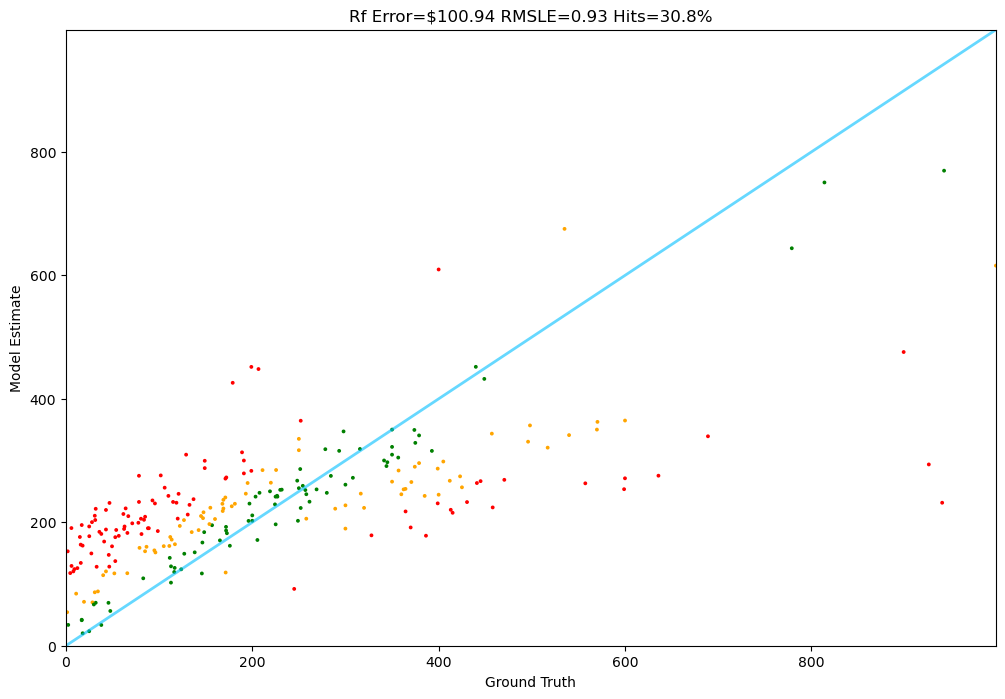

In [12]:
Tester.test(rf, test)

In [13]:
product = "Micrófono de condensador Quadcast HyperX para audio de alta calidad para podcasting"

In [14]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
139.99
284.3106500000003


In [15]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|███████████████████████████████████████████████████████████████| 250/250 [10:53<00:00,  2.61s/it]


In [16]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convertimos a un objeto Series la y
y = pd.Series(prices)

In [17]:
# Entrenamos una Regresión Lineal
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.47
Frontier: 0.07
RandomForest: -0.44
Min: 0.48
Max: 0.40
Intercept=26.27


In [18]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [19]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [20]:
ensemble.price(product)

180.05126420569974

In [21]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $419.20 Truth: $374.41 Error: $44.79 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $204.86 Truth: $225.11 Error: $20.25 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.02 Truth: $61.68 Error: $11.66 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $375.96 Truth: $599.99 Error: $224.03 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $38.50 Truth: $16.99 Error: $21.51 SLE: 0.62 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $37.81 Truth: $31.99 Error: $5.82 SLE: 0.03 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.11 Truth: $101.79 Error: $13.32 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $338.87 Truth: $289.00 Error: $49.87 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $908.45 Truth: $635.86 Error: $272.59 SLE: 0.13 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $74.05 Truth: $65.99 Error: $8.06 SLE: 0.01 It

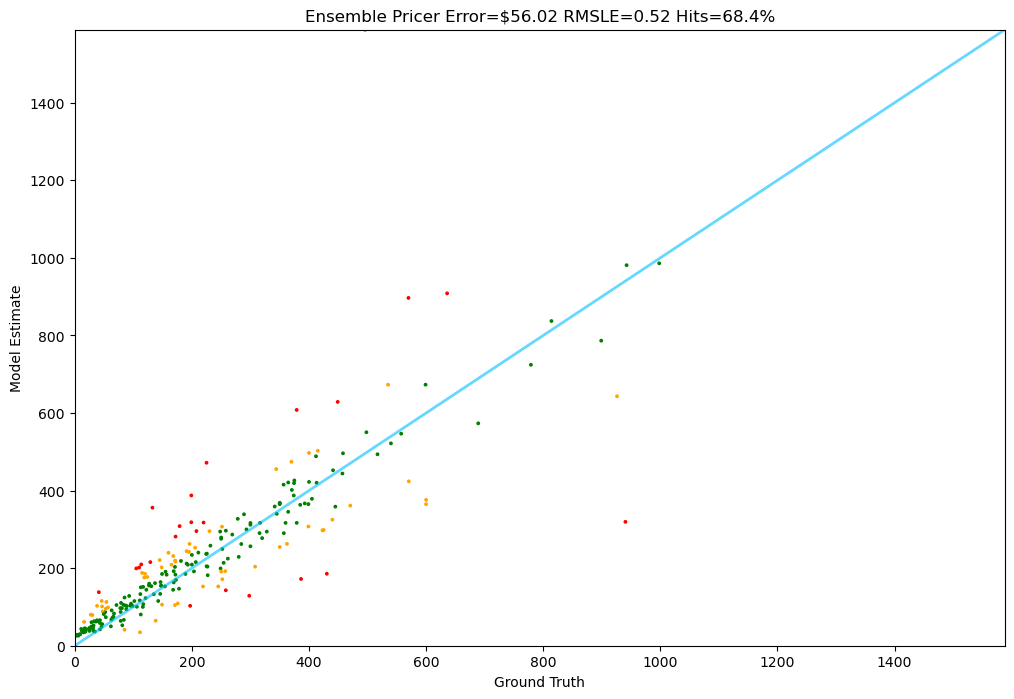

In [22]:
Tester.test(ensemble_pricer, test)

# ¡QUÉ DÍA!

Hicimos mucho: una pipeline RAG de Fronter, un modelo de bosque aleatorio que utiliza codificaciones basadas en transformadores y un modelo de conjunto.

¡Seguro que puedes hacerlo mejor!

Modifica esto e intenta agregar componentes al conjunto para superar mi resultado.